 # ANN Definition


In [1]:
# Import PyTorch library
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, flatten, device
from tqdm import tqdm, trange
from scipy import sparse
import json

In [2]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [3]:
class network(nn.Module):
    def __init__(self, input_size, output_size, dropout, l1, l2, l3, activation=F.relu):
        super().__init__()
        
        # use 3 layers and fc layer
        self.activation = activation

        self.dropout = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout / 2)
        if torch.cuda.is_available():
            self.device = device("cuda")

        self.lin1 = nn.Linear(input_size, l1).to(self.device)
        self.lin2 = nn.Linear(l1, l2).to(self.device)
        self.lin3 = nn.Linear(l2, l3).to(self.device)
        self.fc = nn.Linear(l3, output_size).to(self.device)

    def forward(self, x):
        if torch.cuda.is_available():
            x = x.to(self.device)

        x = self.activation(self.lin1(x))
        x = self.activation(self.lin2(x))
        x = self.activation(self.lin3(x))
        x = self.dropout(x)
        output = self.fc(x)
        return output

In [4]:
cuda = torch.device('cuda')

# General Imports

In [5]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import os

tqdm.pandas() #for progres_apply etc.

# Reading

In [6]:
def load_interactions(path, n_splits=5):
    df = pd.read_pickle(os.path.join(os.getcwd(), path))
    df[['interactions', 'train', 'val', 'test']] = df[['interactions', 'train', 'val', 'test']].applymap(lambda x: np.array(x, dtype=np.int32))
    interactions_dict = {}
    for split in trange(n_splits):
        for column in ['train', 'val', 'test']:
            interactions_dict[split, column] = pd.DataFrame({
                'user_id': df['user_id'],
                'steam_id': df['steam_id'],
                'item_id': df[column].apply(lambda x: x[split, 0]),
                'playtime_forever': df[column].apply(lambda x: x[split, 1]),
                'playtime_2weeks': df[column].apply(lambda x: x[split, 2])})
    return interactions_dict

In [7]:
interactions = load_interactions("./data-cleaned/interactions_splits.pkl.gz")
interactions[0, 'train'].head()
games = pd.read_pickle(os.path.join(os.getcwd(), "./data-cleaned/games.pkl.gz"))
games.head()

100%|██████████| 5/5 [00:00<00:00,  8.28it/s]


,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore,users_count
0,Rockstar Games,[Action],Grand Theft Auto: Episodes from Liberty City,Grand Theft Auto: Episodes from Liberty City,http://store.steampowered.com/app/12220/Grand_...,2010-04-12,"[Open World, Action, Third Person, Multiplayer...",NaN,http://steamcommunity.com/app/12220/reviews/?b...,"[Single-player, Multi-player]",19.99,False,12220,Rockstar North / Toronto,Mostly Positive,NaN,7597
1,Valve,[Action],Half-Life,Half-Life,http://store.steampowered.com/app/70/HalfLife/,1998-11-08,"[FPS, Classic, Action, Sci-fi, Singleplayer, S...",NaN,http://steamcommunity.com/app/70/reviews/?brow...,"[Single-player, Multi-player, Valve Anti-Cheat...",9.99,False,70,Valve,Overwhelmingly Positive,96,7575
2,"Trion Worlds, Inc.","[Action, Free to Play, Massively Multiplayer, ...",Defiance,Defiance,http://store.steampowered.com/app/224600/Defia...,2014-06-04,"[Free to Play, Action, Open World, Massively M...",NaN,http://steamcommunity.com/app/224600/reviews/?...,"[Multi-player, MMO, Co-op, Steam Trading Cards...",Free to Play,False,224600,"Trion Worlds, Inc.",Mostly Positive,64,7539
3,Bohemia Interactive,"[Action, Simulation, Strategy]",Arma 3,Arma 3,http://store.steampowered.com/app/107410/Arma_3/,2013-09-12,"[Simulation, Military, Multiplayer, Realistic,...",NaN,http://steamcommunity.com/app/107410/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",39.99,False,107410,Bohemia Interactive,Very Positive,74,7527
4,Unknown Worlds Entertainment,"[Action, Indie, Strategy]",Natural Selection 2,Natural Selection 2,http://store.steampowered.com/app/4920/Natural...,2012-10-30,"[Multiplayer, Strategy, FPS, Team-Based, Actio...",NaN,http://steamcommunity.com/app/4920/reviews/?br...,"[Multi-player, Online Multi-Player, Steam Achi...",9.99,False,4920,Unknown Worlds Entertainment,Very Positive,80,7502


In [8]:
categories = pd.read_pickle(os.path.join(os.getcwd(), "./data-cleaned/categories.pkl.gz"))
categories.head()

,category,count
0,Single-player,6749
1,Indie,5020
2,Steam Achievements,4072
3,Steam Trading Cards,3641
4,Action,3525


In [9]:
train0 = interactions[0, 'train']
test0 = interactions[0, 'test']
train1 = interactions[1, 'train']
test1 = interactions[1, 'test']
train2 = interactions[2, 'train']
test2 = interactions[2, 'test']

In [10]:
train0["item_id"].map(len).describe()

count    54190.000000
mean        25.977265
std         42.254444
min          1.000000
25%          5.000000
50%         13.000000
75%         30.000000
max        674.000000
Name: item_id, dtype: float64

In [11]:
train0.iloc[100,:]

user_id                                                 EucHellscythe
steam_id                                            76561198072757340
item_id             [991, 214, 4594, 1262, 30, 3449, 959, 964, 436...
playtime_forever    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
playtime_2weeks     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: 100, dtype: object

In [12]:
for train in [train0, train1, train2]:
    train["total_playtime"] = train["playtime_forever"].apply(lambda x: sum(x))
    train["total_playtime_2weeks"] = train["playtime_2weeks"].apply(lambda x: sum(x))
    train["total_items"] = train["item_id"].apply(lambda x: len(x))

In [13]:
train0[["total_playtime", "total_playtime_2weeks", "total_items"]].describe()

,total_playtime,total_playtime_2weeks,total_items
count,54190.000000,54190.000000,54190.000000
mean,11501.441225,138.226296,25.977265
std,20851.541763,624.444600,42.254444
min,0.000000,0.000000,1.000000
25%,1037.250000,0.000000,5.000000
50%,4389.000000,0.000000,13.000000
75%,13355.750000,11.000000,30.000000
max,647435.000000,42770.000000,674.000000


In [14]:
print(train0.iloc[0:10000, -3:].values.shape)
train0.iloc[0:10000, -3:].values

(10000, 3)


array([[151376,    159,    674],
       [344084,   4820,    674],
       [ 25932,    181,    660],
       ...,
       [ 10639,     35,     38],
       [  2188,      0,     38],
       [ 20127,      0,     38]], dtype=int64)

## Score Function

In [15]:
def to_simple_rating(playtime):
    if playtime < 120:
        # less than 2 hrs
        return 1
    elif playtime < 240:
        # less than 4 hrs
        return 2
    elif playtime < 600:
        # less than 10 hrs
        return 3
    elif playtime < 24*60:
        # less than 24 hrs
        return 4
    else:
        return 5

def to_simple_rating2(playtime):
    if playtime < 10:
        # less than 2 hrs
        return 1
    elif playtime < 60:
        # less than 4 hrs
        return 2
    elif playtime < 240:
        # less than 10 hrs
        return 3
    elif playtime < 600:
        # less than 24 hrs
        return 4
    else:
        return 5
        
def rating(playtime):
    if playtime < 1:
        return 1
    else:
        return 2

# works very badly
def to_user_rating(playtime, max_playtime):
    if max_playtime == 0:
        return 1
    return round(playtime / max_playtime * 4) + 1
   
def log_playtime(playtime):
    return np.log2(playtime)

## Sparse Matrix

In [16]:

#Create scipy csr matrix
def get_sparse_matrix(df):
    shape = (df.shape[0], games.shape[0])
    
    user_ids = []
    item_ids = []
    values = []
    for idx, row in df.iterrows():
        items = row['item_id']
        user = idx
        score = row["playtime_forever"] + 2* row["playtime_2weeks"]
        
        # recommended = row['recommended']
        user_ids.extend([user] * len(items))
        item_ids.extend(items)
        # values.extend([to_simple_rating(score[i]) for i in range(len(items))])
        values.extend([to_simple_rating(score[i]) for i in range(len(items))])
    # create csr matrix
    # values = np.ones(len(user_ids))
    matrix = sparse.csr_matrix((values, (user_ids, item_ids)), shape=shape, dtype=np.int32)
    return matrix

# Evaluation

In [17]:
def compute_hr(train_df, train_matrix, test_matrix, rbm, k=10, batch_size=100, rating_cutoff=-1):
    hitrates = []
    recall = []
    nDCG = []
    # for loop - go through every single user
    for id_user in range(0, train_matrix.shape[0] - batch_size, batch_size): # - batch_size, batch_size):
        vt = test_matrix[id_user:id_user + batch_size]  # target
        if vt.getnnz() == 0:
            continue

        vt = convert_sparse_matrix_to_sparse_tensor(vt)
        vt = vt.to_dense()
        vt = vt.sub(1)
        if torch.cuda.is_available():
            vt = vt.cuda()

        # ground truth
        # sort games by their rating in each user vector
        target_recommended = torch.argsort(vt, 1, descending=True)

        # predicted
        v = train_matrix[id_user:id_user + batch_size]  # training set inputs are used to activate neurons of my RBM
        v = convert_to_user_tensor(v, train_df[id_user:id_user + batch_size])
        ratings = v[:,:-3]
        recommended = rbm(v)
        recommended[ratings != -1] = -10    # do not recommend games already in the users library
        predicted_rating, predicted_movie = torch.topk(recommended, k)

        # TODO optimize range s.t. users without target are skipped
        for user in range(batch_size):

            # all recommendations
            # truth: games that are in inventory thus > -1
            user_ratings = torch.index_select(vt[user], 0, target_recommended[user])    # get ratings for sorted tensor
            user_target = target_recommended[user][user_ratings > rating_cutoff].cpu().tolist()   # get games with min rating

            user_pred = predicted_movie[user].cpu().tolist()

            counter = 0
            total = min(k, len(user_target))
            for target in user_target:
                if target in user_pred:
                    counter += 1
            # counter = len(recommendations)

            recall.append(counter / total)
            hitrates.append(min(1, counter))

            # nDCG
            idcg = np.sum([1 / np.log2(i+2) for i in range(min(k, len(user_target)))])
            dcg = 0
            for i, r in enumerate(user_pred):
                if r in user_target:
                    dcg += 1 / np.log2(i+2)

            nDCG.append(dcg / idcg) 

    return hitrates, recall, nDCG

# Train model

In [18]:
def params_to_str(params):
    return "-".join([s.__name__ if callable(s) else str(s) for s in params] )

def score_model(rbm, batch_size, train_df, train_matrix, test_matrix):
    test_recon_error = 0  # RMSE reconstruction error initialized to 0 at the beginning of training
    s = 0  # a counter (float type) 
    # for loop - go through every single user
    for id_user in range(0, train_matrix.shape[0] - batch_size, batch_size):
        v = train_matrix[id_user:id_user + batch_size]  # training set inputs are used to activate neurons of my RBM
        v = convert_to_user_tensor(v, train_df[id_user:id_user + batch_size])

        vt = test_matrix[id_user:id_user + batch_size]  # target
        vt = convert_sparse_matrix_to_sparse_tensor(vt)
        vt = vt.to_dense()
        vt = vt.sub(1)
        if torch.cuda.is_available():
            vt = vt.cuda()

        if len(vt[vt > -1]) > 0:
            vk = rbm(v)
            # Update test RMSE reconstruction error
            loss = torch.sqrt(torch.mean((vt[vt > -1] - vk[vt > -1])**2))
            loss.backward()
            test_recon_error += loss
            s += 1

    return test_recon_error / s 


# https://stackoverflow.com/questions/40896157/scipy-sparse-csr-matrix-to-tensorflow-sparsetensor-mini-batch-gradient-descent
def convert_sparse_matrix_to_sparse_tensor(X, k=5):
    coo = X.tocoo()

    values = coo.data
    indices = np.vstack((coo.row, coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    # print(values)
    # print("values", v)
    shape = coo.shape
    tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape)) 
    if torch.cuda.is_available():
        tensor = tensor.cuda()

    return tensor 

def convert_to_user_tensor(X: sparse.csr_matrix, users: pd.DataFrame):
    coo = X.tocoo()

    values = coo.data
    indices = np.vstack((coo.row, coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = coo.shape
    tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape)) 
    if torch.cuda.is_available():
        tensor = tensor.cuda()

    tensor = tensor.to_dense()
    tensor = tensor.sub(1)

    users_tensor = torch.Tensor(users.values)
    if torch.cuda.is_available():
        users_tensor = users_tensor.cuda()
    if len(users_tensor.shape) == 1:
        users_tensor = users_tensor.unsqueeze(0)
    tensor = torch.cat([tensor, users_tensor], dim=1)
    return tensor 

    
def create_rbm(train_df: pd.DataFrame, train_matrix, test_matrix, batch_size, epochs, params, model=None, k=5, hrmod=20, lr=0.02, stop=False):
    n_vis = train_matrix.shape[1] + train_df.shape[1]
    train_errors = []
    test_errors = []
    if model is None:
        model = network(n_vis, train_matrix.shape[1], *params)
    optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    metrics = {
        "hr": [],
        "r": [],
        "ndcg": []
    }

    print("start training")
    for epoch in trange(epochs):
        model.train()
        train_recon_error = 0  # RMSE reconstruction error initialized to 0 at the beginning of training
        s = 0
        
        for user_id in range(0, train_matrix.shape[0] - batch_size, batch_size):
            training_sample = train_matrix[user_id : user_id + batch_size]
            v0 = convert_to_user_tensor(training_sample, train_df[user_id: user_id + batch_size])
            
            optim.zero_grad()            
            vk = model(v0)
            ratings = v0[:,:-train_df.shape[1]]
            loss = torch.sqrt(torch.mean((ratings[ratings > -1] - vk[ratings > -1])**2))
            loss.backward()
            optim.step()
            train_recon_error +=loss
            s += 1
            
        train_errors.append(train_recon_error / s)

        model.eval()
        test_errors.append(score_model(model, batch_size, train_df, train_matrix, test_matrix))

        if epoch % hrmod == hrmod - 1:
            hr, r, ndcg = compute_hr(train_df, train_matrix, test_matrix, model, batch_size=batch_size)
            metrics["hr"].append(np.average(hr))
            metrics["r"].append(np.average(r))
            metrics["ndcg"].append(np.average(ndcg))
            if stop and len(metrics["hr"]) > 2:
                hr1 = metrics["hr"][-3]
                hr2 = metrics["hr"][-2]
                hrnow = metrics["hr"][-1]
                if hrnow < hr1 and hrnow < hr2:
                    print("Hr decreasing => stopping training")
                    break


    import matplotlib.pyplot as plt
    # Plot the RMSE reconstruction error with respect to increasing number of epochs
    plt.plot(np.arange(1, len(train_errors), 1), torch.Tensor(train_errors[1:], device='cpu'), label="train")
    plt.plot(np.arange(1, len(train_errors), 1), torch.Tensor(test_errors[1:], device='cpu'), label="test")
    plt.ylabel('Error')
    plt.xlabel('Epoch')
    plt.legend()


    plt.savefig(f'ann-{params_to_str(params)}-{batch_size}-{epochs}.jpg')
    plt.show()
    plt.clf()

    return model, metrics

# Evaluate the RBM on test set
# test_recon_error = score_model(rbm)
# print("Final error", test_recon_error)


rbm

In [19]:
# rbm10 = create_rbm(train_matrix, test_matrix, 1000, 10000, 200)

In [20]:
# torch.save(rbm10.state_dict(), "./ann-20-50-20-steam400-train0")

hr

In [21]:
# hr, r, ndcg = compute_hr(train_matrix, test_matrix, rbm10, k=10, batch_size=15000)

In [22]:
# print(np.average(hr), np.average(r), np.average(ndcg))

In [23]:
# rbm = RBM(n_vis, n_hidden)
# rbm.load_state_dict(torch.load("./network"))
# rbm.eval()

# Hyperparam Tuning

In [24]:
train_matrix = get_sparse_matrix(train0)
test_matrix = get_sparse_matrix(test0)

In [57]:
l1s = np.arange(16, 33, 16)
l2s = np.arange(24, 65, 8)
l3s = np.arange(24, 129, 16)
# l1s = [48]
# l2s = [32, 48]
# dropouts = [0.1, 0.2, 0.3]
dropouts = [0.1]

epochs = 100
activation = torch.tanh

for l1 in l1s:
    for l2 in l2s:
        for l3 in l3s:
            for dropout in dropouts:
                model, metrics = create_rbm(train_matrix, test_matrix, 10000, epochs, (dropout, l1, l2, l3, activation), hrmod=20)
                
                torch.save(model.state_dict(), f"./ann-rating-{l1}-{l2}-{l3}-{dropout}-steam{epochs}-train0")
                with open(f"metrics-rating-{l1}-{l2}-{l3}-{dropout}.json", "w") as f:
                    f.write(json.dumps(metrics))

TypeError: create_rbm() missing 1 required positional argument: 'params'

start training


 50%|████▉     | 399/800 [05:13<05:14,  1.27it/s]

Hr decreasing => stopping training


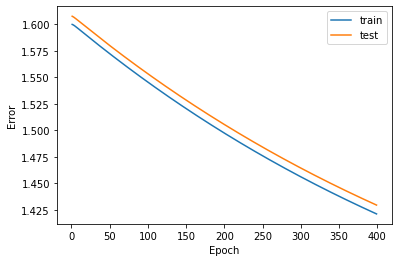

<Figure size 432x288 with 0 Axes>

In [34]:
from datetime import datetime
nowstring = datetime.now().strftime('%H-%M-%S')
dropout, l1, l2, l3, activation, lr = 0.2, 128, 64, 16, F.relu, 0.01
epochs = 800
user_df = train0[["total_playtime", "total_playtime_2weeks", "total_items"]]
model, metrics = create_rbm(user_df, train_matrix, test_matrix, 10000, epochs, (dropout, l1, l2, l3, activation), hrmod=50, lr=lr, stop=True)

torch.save(model.state_dict(), f"./ann-totals-1-{l1}-{l2}-{l3}-{dropout}-steam{epochs}-train0-{nowstring}")
with open(f"metrics-{activation.__name__}-totals-1-{epochs}-{l1}-{l2}-{l3}-{dropout}-lr{lr}-{nowstring}.json", "w") as f:
    f.write(json.dumps(metrics))

{'hr': [0.02092, 0.02184, 0.05784, 0.07898, 0.10908, 0.13518, 0.1385, 0.14902, 0.17202, 0.17518, 0.17642, 0.17554, 0.16718], 'r': [0.0053179523809523815, 0.005455738095238096, 0.015239912698412697, 0.02092242857142857, 0.027974396825396826, 0.035938142857142856, 0.03684548412698412, 0.03952526984126984, 0.04602168253968254, 0.04685523015873016, 0.04698396825396825, 0.04672749206349206, 0.04464774603174603], 'ndcg': [0.003014347970197977, 0.0039156740634525514, 0.010858190529148475, 0.018583935004358322, 0.023416993533887372, 0.02747981290640434, 0.02871717675759566, 0.030487069005512932, 0.033653672359557366, 0.03377645054226801, 0.034044765153482315, 0.03396490038177297, 0.03296249616614434]}

In [27]:
compute_hr(user_df, train_matrix, test_matrix, model, batch_size=10000)

In [44]:
h, r, n = compute_hr(train0.iloc[:,-3:], train_matrix, test_matrix, model, batch_size=2000, rating_cutoff=1)
print(np.average(h))
print(np.average(r))
print(np.average(n))

0.20951273915365523
0.11312144295792312
0.06839786776709574


In [27]:
from pprint import pprint
pprint(metrics)

{'hr': [0.1266, 0.16632, 0.17904, 0.17428, 0.1739],
 'ndcg': [0.02502139818524457,
          0.03166694717147871,
          0.03542391021837664,
          0.034812449886339074,
          0.03482520598587783],
 'r': [0.033360992063492065,
       0.045283396825396824,
       0.04962761111111111,
       0.04837514285714285,
       0.04804781746031746]}


# Recommend for set users

In [27]:
def recommend(model: network, train_df, train_matrix, test_matrix, userid, k=10):
    vt = test_matrix[userid]  # target
    vt = convert_sparse_matrix_to_sparse_tensor(vt)
    vt = vt.to_dense()
    vt = vt.sub(1)
    if torch.cuda.is_available():
        vt = vt.cuda()

    # ground truth
    users, movies = (vt > -1).nonzero(as_tuple=True)

    indices = torch.stack([users, movies])
    shape = (1, train_matrix.shape[1])
    target = torch.sparse.LongTensor(indices, torch.add(vt[vt > -1].flatten(), 1), torch.Size(shape))
    target_dense = target.to_dense()

    target_rating, target_movie = torch.topk(target_dense, k, 1)
    # target_movie[target_rating < 3] = -1 # remove all bad movies from top k

    # values, _ = torch.max(target_rating, dim=1)
    # users_with_target = (values > 0).nonzero(as_tuple=True)[0].cpu().tolist()


    # predicted
    v = train_matrix[userid]  # training set inputs are used to activate neurons of my RBM
    v = convert_to_user_tensor(v, train_df.iloc[userid, ])
    ratings = v[:,:-3]
    recommended = model(v)
    recommended[ratings != -1] = -10
    predicted_rating, predicted_movie = torch.topk(recommended, k)


    # all recommendations
    user_target = target_movie[0][target_rating[0] > 0].cpu().tolist()
    user_pred = predicted_movie[0].cpu().tolist()

    counter = 0
    total = min(k, len(user_target))
    for target in user_target:
        if target in user_pred:
            counter += 1
    # counter = len(recommendations)

    recall = counter / total

    # nDCG
    idcg = np.sum([1 / np.log2(i+2) for i in range(min(k, len(user_target)))])
    dcg = 0
    for i, r in enumerate(user_pred):
        if r in user_target:
            dcg += 1 / np.log2(i+2)

    ndcg = dcg / idcg
    return user_pred, user_target, recall, ndcg

In [60]:
print(recommend(model, train0.iloc[:,-3:], train_matrix, test_matrix, 30000))
print(recommend(model, train0.iloc[:,-3:], train_matrix, test_matrix, 30001))
print(recommend(model, train0.iloc[:,-3:], train_matrix, test_matrix, 42069))

([3, 14, 39, 5, 17, 11, 82, 20, 62, 35], [432, 60], 0.0, 0.0)
([3, 14, 39, 5, 17, 11, 82, 20, 62, 35], [84, 25], 0.0, 0.0)
([3, 14, 39, 5, 11, 82, 20, 62, 35, 41], [329], 0.0, 0.0)


In [44]:
for user in [30000, 30001, 42069]:
    inventory = train0.loc[user]["item_id"]
    recommended, target, r, ndcg = recommend(model, train0.iloc[:,-3:], train_matrix, test_matrix, user)
    print(games.loc[inventory]["title"].tolist())
    print(games.loc[target]["title"].tolist())
    print(games.loc[recommended]["title"].tolist())
    print()


['Black Rose', 'Shadow Warrior', 'Tropico 4', 'Cry of Fear', 'Resident Evil Revelations / Biohazard Revelations', 'Riders of Icarus', 'Eternal Senia', 'Resident Evil 6 / Biohazard 6', 'FINAL FANTASY X/X-2 HD Remaster', 'Dying Light', 'DARK SOULS™ II: Scholar of the First Sin']
['Resident Evil Revelations 2 / Biohazard Revelations 2', 'Fractured Space']
['Arma 3', 'Mount &amp; Blade: Warband', 'The Binding of Isaac: Rebirth', 'Borderlands: The Pre-Sequel', 'Dungeon Defenders', 'Kerbal Space Program', 'Dishonored', 'Left 4 Dead', 'The Forest', 'The Walking Dead']

['Double Action: Boogaloo', 'EVGA Precision XOC', 'World of Soccer online', 'Brick-Force', 'BlackShot: Mercenary Warfare FPS', 'Block N Load', 'Survarium', 'Codename CURE', 'sZone-Online', 'BLOCKADE 3D', 'WARMODE']
['GunZ 2: The Second Duel', 'Dungeon Defenders II']
['Arma 3', 'Mount &amp; Blade: Warband', 'The Binding of Isaac: Rebirth', 'Borderlands: The Pre-Sequel', 'Dungeon Defenders', 'Kerbal Space Program', 'Dishonored', 

In [47]:
h, r, n = compute_hr(train0.iloc[:,-3:], train_matrix, test_matrix, model, k=5)
print(np.average(h))
print(np.average(r))
print(np.average(n))

0.09859519408502773
0.03190819470117067
0.027869848559032552


In [46]:
h, r, n = compute_hr(train0.iloc[:,-3:], train_matrix, test_matrix, model, k=20)
print(np.average(h))
print(np.average(r))
print(np.average(n))

0.27049907578558224
0.0843493876164727
0.04674087290171155
